In [601]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d

color_list =["#3eb991","#e9a820","#e01563","#edb196","#6ecadc","#1f94ac","#ae9a6a","#ccb8a6","#343a44"]

In [602]:
# defining function for diffusion in 3D over time
def single_step(X, Y, theta, delta_T):
    
    # defining variables
    v = 1 * pow(10, -6); 
    omega = 0; 
    D_r = 0.05; 
    D_t = 0.1 * pow(10, -12); 

    delta_X, delta_Y = 0, 0; 
    delta_theta = 0; 

    # randomly sampling in a uniform distribution from 0 to 1 to get an angle
    W_theta = (math.pi / 2) * random.uniform(-1, 1); 

    # randomly sampling noise in Gaussian distrib. with mean 0 and variance 1
    W_X = np.random.normal(0, 1); 
    W_Y = np.random.normal(0, 1); 

    # solving change in position for each dimension
    delta_X = v * np.cos(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_X; 
    delta_Y = v * np.sin(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_Y; 

    # solving change in each angle
    delta_theta = omega * delta_T + np.sqrt(2 * D_r * delta_T) * W_theta; 

    # using a temporary variable to track position and angle
    X += delta_X; 
    Y += delta_Y; 
    theta += delta_theta; 
    
    temp_postition = []; 
    temp_postition = np.array([X, Y, theta]); 

    return temp_postition; # returning coordinates and diffusion coefficient (for comparison later)

In [603]:
class makeSwimmer: # defines swimmer class
  def __init__(self, x, y, theta, start_time): # one can enter with 0, 0, 0 start or other
    self.start_time = start_time; 
    self.position = np.array([x, y, theta]); 

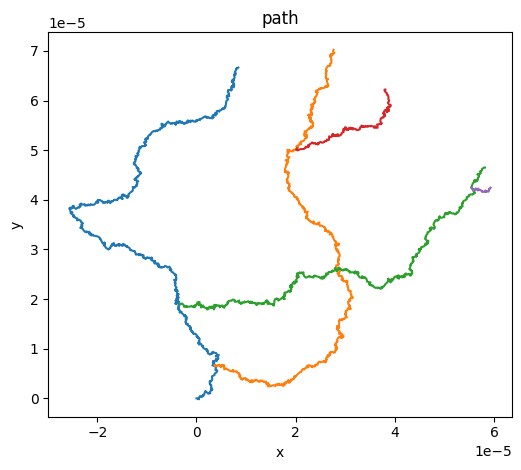

In [604]:
total_time = 100; 
delta_T = 0.1; 
indexed_time = int(total_time / delta_T); # used to index through time list 

swimmerList = []; # a list of swimmers
for i in range(0, 1, 1): # initializes a list of 10 swimmers 
    swimmerList.append(makeSwimmer(0, 0, 0, 0)); # set starting point at 0, 0

for time in range(0, indexed_time, 1):
    for i in range(0, len(swimmerList), 1):
        if (time == 0) or (time == swimmerList[i].start_time + 1 and time != 1): 
            arr = swimmerList[i].position; # just adding this to reduce lines. could do swimmerList[i].position[0] instead
        elif (swimmerList[i].start_time == 0): 
            arr = swimmerList[i].position[time]; # I think this is needed, otherwise it awkwardly tries to stack 2d arrays
        else: 
            arr = swimmerList[i].position[time - swimmerList[i].start_time - 1]; 
        swimmerList[i].position = np.vstack((swimmerList[i].position, single_step(arr[0], arr[1], arr[2], delta_T)));  
        
        random_swimmer_generator = np.random.normal(0, 1); 
        if random_swimmer_generator > 3:
            temp_x = swimmerList[i].position[time - swimmerList[i].start_time,0]; 
            temp_y = swimmerList[i].position[time - swimmerList[i].start_time,1]; 
            swimmerList.append(makeSwimmer(temp_x, temp_y, 0, time)); # set starting point at 0, 0

# 2d graphing definitions
fig, ax = plt.subplots()
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1]); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plt.plot then graphs all of those x and y independently 

plt.xlabel('x')
plt.ylabel('y')
ax.set_title("path")
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()